In [ ]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import yfinance as yf
from fbprophet import Prophet

In [15]:
msft = yf.Ticker("EGGUB.IS")
hist = msft.history(period="60d")
hist["Date"] = hist.index
hist = hist.set_index([[i for i in range(len(hist))]])

<AxesSubplot:xlabel='Date'>

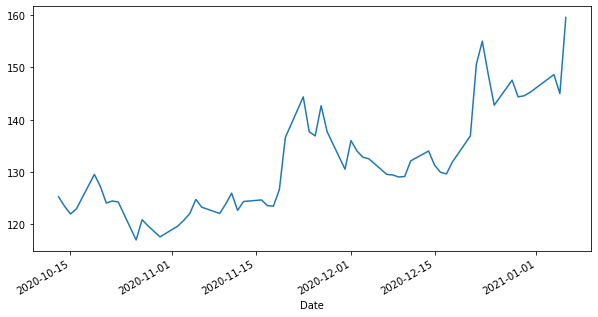

In [6]:
hist['Close'].plot(figsize=(10, 5))

In [9]:


data = pd.read_csv("EGGUB.IS.csv") 
data.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-13,123.190378,131.734232,121.799517,125.276665,404349,0.0,0
2020-10-14,125.972095,127.959037,122.892330,123.488419,272867,0.0,0
2020-10-15,123.885803,123.885803,121.501479,121.998215,70487,0.0,0
2020-10-16,122.296250,124.879272,121.998213,122.991684,82530,0.0,0
2020-10-19,129.151202,131.237496,126.667525,129.548584,392351,0.0,0


In [10]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,60.000000,60.000000,60.000000,60.000000,6.000000e+01,60.000000,60.0
mean,131.998247,135.511024,129.119829,131.723168,3.023103e+05,0.015833,0.0
std,10.280538,10.967241,9.351394,10.029555,2.945860e+05,0.122644,0.0
min,115.242614,118.719762,113.255673,117.030861,2.919800e+04,0.000000,0.0
25%,124.407381,127.238777,122.296251,123.811295,9.992775e+04,0.000000,0.0
50%,129.697614,132.230957,128.008709,129.548584,2.026695e+05,0.000000,0.0
75%,137.819239,144.351305,135.062352,137.098976,3.668840e+05,0.000000,0.0
max,163.723991,165.512242,153.292548,159.500000,1.534794e+06,0.950000,0.0


In [11]:
data = data[["Date", "Close"]]

data = data.rename(columns = {"Date": "ds", "Close": "y"})
data.head(5)

KeyError: "['Date'] not in index"

In [10]:


m = Prophet(daily_seasonality=True)
m.fit(data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=60)
prediction = m.predict(future)

In [ ]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

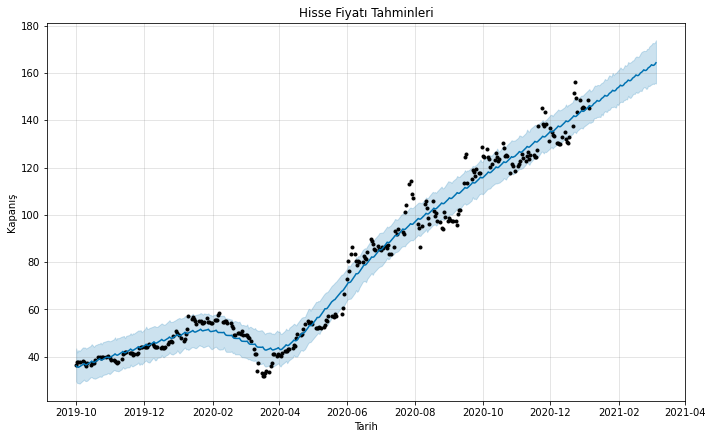

In [11]:
m.plot(prediction)
plt.title("Hisse Fiyatı Tahminleri")
plt.xlabel("Tarih")
plt.ylabel("Kapanış")
plt.show()

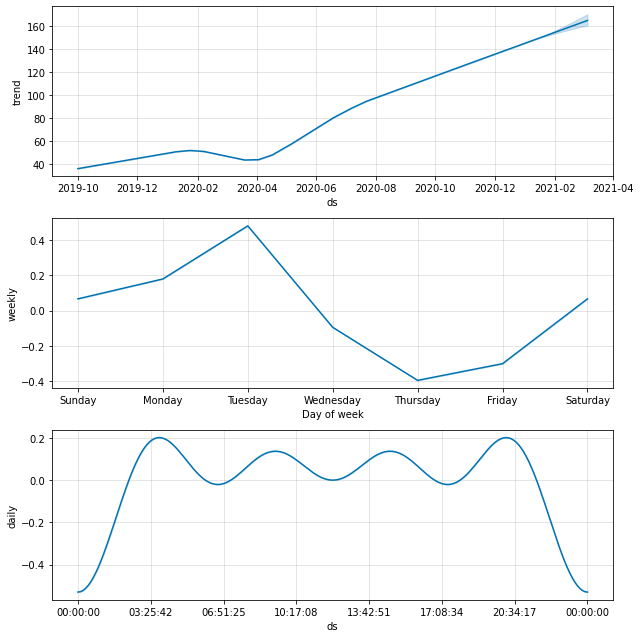

In [12]:
m.plot_components(prediction)
plt.show()